## EDA template

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv('data/Train.zip')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Data Analysis
#### Meta data
* How many samples and features?
* What features are numeric vs. categorical

#### Data
* Inconsistent value types
* Missing values
* Zero values
* Incorrect values: sold before manufactured

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

In [4]:
# pp.ProfileReport(raw_df)

## Subsample for speed

In [5]:
raw_df = raw_df[::10]  
# or use pd.sample()

In [6]:
raw_df.reset_index(inplace=True)
raw_df.head()

,index,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,10,1139278,24000,1024998,4605,121,3.0,2004,1414.0,Medium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,1139311,41000,1014135,8867,121,3.0,2000,3259.0,Medium,...,32 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,30,1139363,51000,871201,1263,121,3.0,1999,15633.0,High,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,40,1139412,39000,108090,1088,121,3.0,2006,1125.0,Medium,...,None or Unspecified,None or Unspecified,Hydraulic,Yes,Triple,NaN,NaN,NaN,NaN,NaN


## Plotting

In [7]:
# pd.plotting.scatter_matrix(raw_df)
# better use seaborn pairplot, see next cell

In [8]:
# sns.pairplot(raw_df)

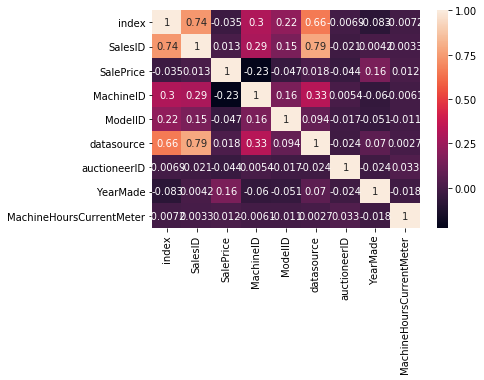

In [9]:
# Useful to get actual correlation numbers
sns.heatmap(raw_df.corr(), annot=True)

In [10]:
# plt.scatter(raw_df['YearMade'], dt.date2num(pd.to_datetime(raw_df['saledate'])))

# 2. Data Cleaning and Preparation
## 2.1 Dates to numerical

In [11]:
# getting correlations with dates by using date2num
import matplotlib.dates as dt

In [12]:
datetime = pd.to_datetime(raw_df['saledate'])

In [13]:
dateNum = dt.date2num(pd.to_datetime(raw_df['saledate']))

## 2.2 Fill missing values

Replace the implausible values of YearMade by using KNN

### Output
X_all: all rows,  cols:ModelID, YearMade (with bad values replaced)

### Local
KNN training: 
X_KNN: rows: YearMade > 1500     cols: ModelID, saledate_num
y_KNN: YearMade

In [14]:
from sklearn.neighbors import KNeighborsRegressor

In [15]:
X_all = raw_df[['ModelID','YearMade']].copy()

In [16]:
X_all.describe()

,ModelID,YearMade
count,40113.000000,40113.000000
mean,6905.466981,1898.589186
std,6256.631237,292.562341
min,28.000000,1000.000000
25%,3261.000000,1985.000000
50%,4604.000000,1995.000000
75%,8724.000000,2000.000000
max,37198.000000,2011.000000


In [17]:
X_all.loc[:,'saledate_num'] = pd.Series(dateNum)

In [18]:
X_KNN = X_all[X_all['YearMade']>1500].copy()

In [19]:
y_KNN = X_KNN['YearMade']
X_KNN.drop('YearMade',axis=1,inplace=True)
X_KNN.head(1)

,ModelID,saledate_num
0,3157,732631.0


In [20]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_KNN, y_KNN) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [21]:
X_to_fill = X_all[X_all['YearMade'] <= 1500].copy()
X_to_fill.drop('YearMade',axis=1,inplace=True)

In [22]:
year_predicted = neigh.predict(X_to_fill)

In [23]:
X_all.loc[X_all['YearMade'] <= 1500, 'YearMade'] = year_predicted

In [24]:
X_all.head(2)

,ModelID,YearMade,saledate_num
0,3157,2004.0,732631.0
1,4605,2004.0,733275.0


In [25]:
X_all.loc[X_all['YearMade'] <= 1500].head()

,ModelID,YearMade,saledate_num


In [26]:
len(X_all.index)

40113

- we replaced all the implausible YearMade values with plausible ones. No '1000's anymore. 

# 3 Linear Regression

In [27]:
import statsmodels.api as sm

In [28]:
X_OLS = X_all
y_OLS = raw_df['SalePrice']

In [29]:
model = sm.OLS(y_OLS, X_OLS)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 2.686e+04
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:42:09   Log-Likelihood:            -4.5847e+05
No. Observations:               40113   AIC:                         9.169e+05
Df Residuals:                   40110   BIC:                         9.170e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ModelID         -0.3273      0.018    -18.146      0.000      -0.363      -0.292
YearMade       740.8371     15.034     49.277      0.000     711.370     770.304
saledate_num    -1.9729      0.041    -48.200      0.000      -2.053      -1.893
==============================================================================
Omnibus:                    10529.604   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24219.750
Skew:                           1.495   Prob(JB):                         0.00
Kurtosis:                       5.357   Cond. No.                     9.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
X_OLS.head(3)

,ModelID,YearMade,saledate_num
0,3157,2004.0,732631.0
1,4605,2004.0,733275.0
2,8867,2000.0,732449.0


## Test Score

In [31]:
X_test = pd.read_csv('data/Test.zip')

In [32]:
df_sol = pd.read_csv("data/do_not_open/test_soln.csv.zip")

dateNum = dt.date2num(pd.to_datetime(X_test['saledate']))
X_test['saledate_num'] = pd.Series(dateNum)
X_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saledate_num
0,1222837,902859,1376,121,3,1000,0.0,NaN,1/5/2012 0:00,375L,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,734507.0
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,1/5/2012 0:00,TX300LC2,...,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN,734507.0
2,1222841,999308,4587,121,3,2000,10127.0,Medium,1/5/2012 0:00,270LC,...,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,734507.0
3,1222843,1062425,1954,121,3,1000,4682.0,Low,1/5/2012 0:00,892DLC,...,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,734507.0
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,1/4/2012 0:00,544H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,734506.0


In [33]:
def score(self, predictions):
        log_diff = np.log(predictions+1) - np.log(self+1)
        return np.sqrt(np.mean(log_diff**2))

In [34]:
X_test = X_test[['ModelID','YearMade','saledate_num']].copy()

In [35]:
X_t_to_fill = X_test[X_test['YearMade'] <= 1500].copy()
X_t_to_fill.drop('YearMade',axis=1,inplace=True)

year_predicted_t = neigh.predict(X_t_to_fill)
# X_test.loc[X_test['YearMade'] <= 1500, 'YearMade'] = year_predicted_t

In [36]:
year_predicted_t

array([1998.5, 1996. , 1989. , ..., 2005. , 1999.5, 2004.5])

In [37]:
X_test.head()

,ModelID,YearMade,saledate_num
0,1376,1000,734507.0
1,36526,2006,734507.0
2,4587,2000,734507.0
3,1954,1000,734507.0
4,4701,2002,734506.0


In [38]:
test_prediction = results.predict(X_test)

In [39]:
rmsle = score(df_sol["SalePrice"], test_prediction)
rmsle

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


0.7183613478870806